# Machine Learning Project:
# Wallstreetbets Sentiment Analysis

## Prep

In [217]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
import re
import emoji

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

# To make stable across runs
np.random.seed(123)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [218]:
# Import data
df = pd.read_csv('data/reddit_wsb.csv')

## Data Exploration

### Feature explanations
> - Title: The title of the Reddit post.
> - Score: The Reddit score associated with the post, indicating the number of upvotes minus the number of downvotes (post's popularity).
> - Id: The unique identifier for each post.
> - Url: The URL of the post.
> - Comms_num: The number of comments on the post (engagement).
> - Created: The timestamp, expressed in epoch time format, of when the post was created.
> - Body: The text content of the post.
> - Timestamp: The timestamp of when the post was created.

In [219]:
df_explore = df.copy()
df_explore = df_explore[['title','body','score','timestamp']]

In [220]:
df_explore.sample(5, random_state=0)

,title,body,score,timestamp
22805,'This is real' — Mark Cuban says Reddit trader...,NaN,6938,2021-02-03 03:18:10
42768,"You’re buying based on gut feeling, selling on...",**Not a trading advise.**\n\nHey there folks a...,4985,2021-03-22 11:34:22
45313,"Anyone remember my 4/23C at 4,200? 5/7C and al...",NaN,33,2021-04-14 01:55:40
26051,Losing more and more . Picture is how i feel b...,NaN,58,2021-02-04 14:03:33
42227,"$TR Tootsie Roll, $AMC and stimmi. Throw in a ...",NaN,45,2021-03-18 02:56:09


In [221]:
# To understand how big the file is and how many variables it has
print('This dataframe has' ,df_explore.shape[0], 'rows and', df_explore.shape[1], 'columns')

This dataframe has 53187 rows and 4 columns


In [222]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      53187 non-null  object
 1   body       24738 non-null  object
 2   score      53187 non-null  int64 
 3   timestamp  53187 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


- We can see that more of 50% of the 'body' feature are NULL
- Dates range are from January 28th, 2021 to August 2nd, 2021. Seven months of data.

In [223]:
# Function to visualize the word cloud and word frequency for a given feature

def word_cloud(text_feature, title_or_body):
    titles = text_feature

    # Combining all titles into a single string
    all_titles = ' '.join(titles)

    # Tokenizing the text (process of breaking down a text into individual units)
    tokens = word_tokenize(all_titles)

    # Removing stopwords
    stop_words = set(stopwords.words('english')) # Creates a set of common English stop words (ex: 'and', 'to') 
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # Word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

    # Word Cloud plot
    plt.figure(figsize=(10, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
   # Analyze Word Frequency
    word_freq = Counter(filtered_tokens)
    df_explore_word_freq = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    df_explore_word_freq = df_explore_word_freq.sort_values(by='Frequency', ascending=False)

    # Plot the top N words by frequency
    top_n = 15
    plt.figure(figsize=(15, 4))
    plt.bar(df_explore_word_freq['Word'][:top_n], df_explore_word_freq['Frequency'][:top_n], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in {title_or_body}')
    plt.show()

**`Feature title`**
> Let's see what words/stocks are the most common 

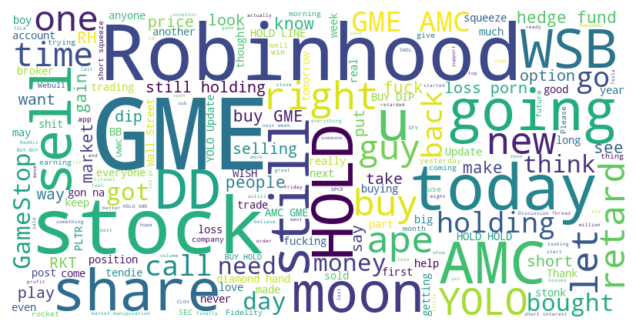

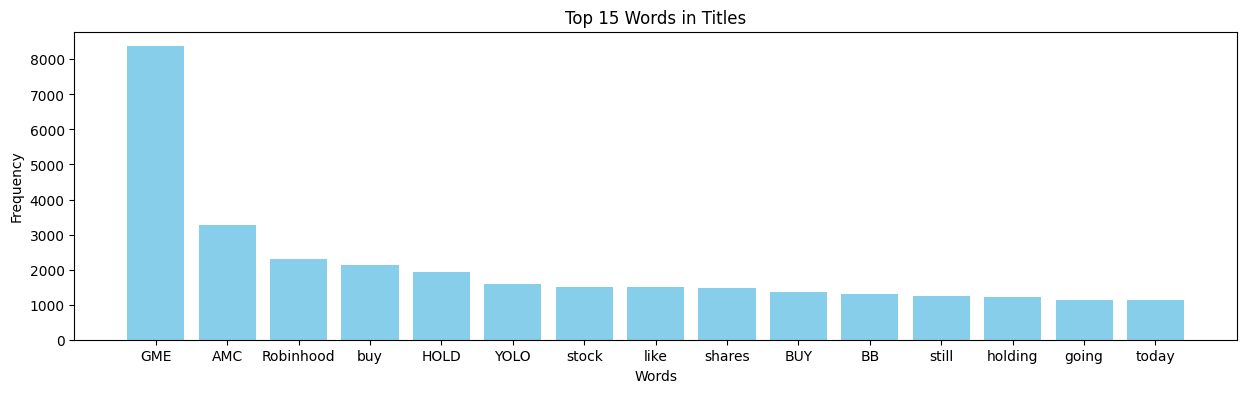

In [224]:
word_cloud(df_explore['title'], 'Titles')

**`Feature body`**
> We are going to repeat here the same exercise that we did for the feature 'title', to catch the words/stocks that are more frequent

In [225]:
print('\033[1mThere are', df_explore['body'].isnull().sum(), 'nulls in the "body" column')

There are 28449 nulls in the "body" column


In [226]:
# We are going to use only the observations with texts in the 'body' column
df_body = df_explore[df_explore['body'].notnull()]
df_body.head(2)

,title,body,score,timestamp
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,0,2021-01-28 21:30:35
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,Hedgefund whales are spreading disinfo saying ...,317,2021-01-28 21:26:27


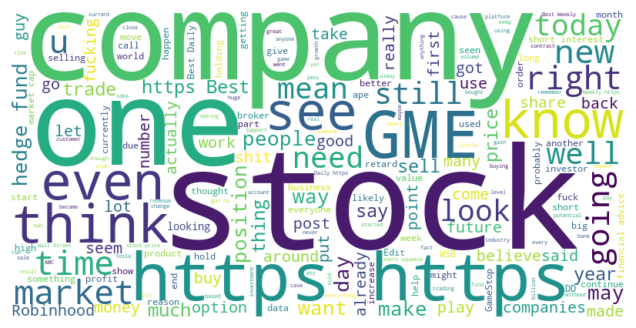

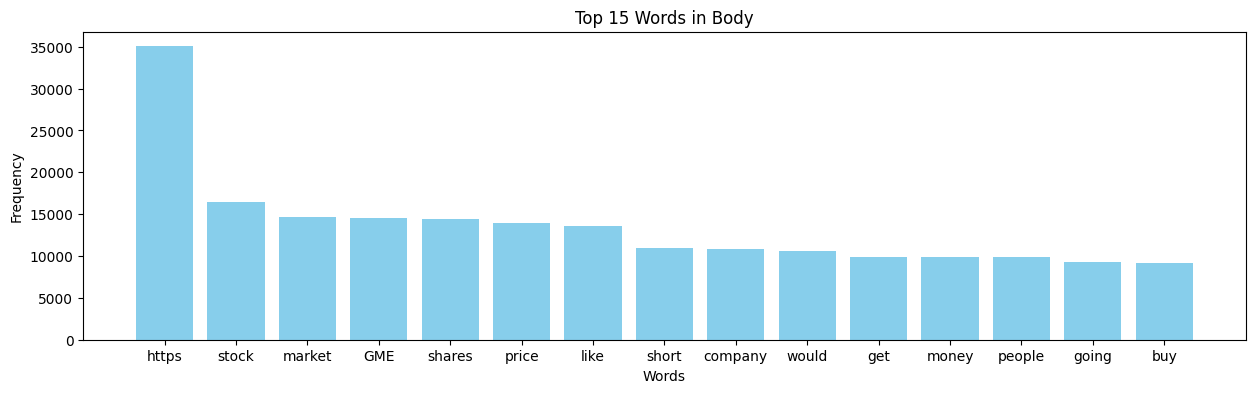

In [227]:
word_cloud(df_body['body'], 'Body')

**`Feature Score`**

In [228]:
df_explore['score'].unique()

array([   55,   110,     0, ...,  2997, 45436,  7398], dtype=int64)

In [229]:
# Looking for negative values
df_explore[(df_explore['score'] <0)].sum()

title        0
body         0
score        0
timestamp    0
dtype: object

In [230]:
df_explore['score'].describe()

count     53187.000000
mean       1382.461053
std        7999.271074
min           0.000000
25%           2.000000
50%          37.000000
75%         207.000000
max      348241.000000
Name: score, dtype: float64

In [231]:
# Post with highest score
df_explore[df_explore['score']==348241]

,title,body,score,timestamp
19162,Times Square right now,NaN,348241,2021-01-31 04:00:38


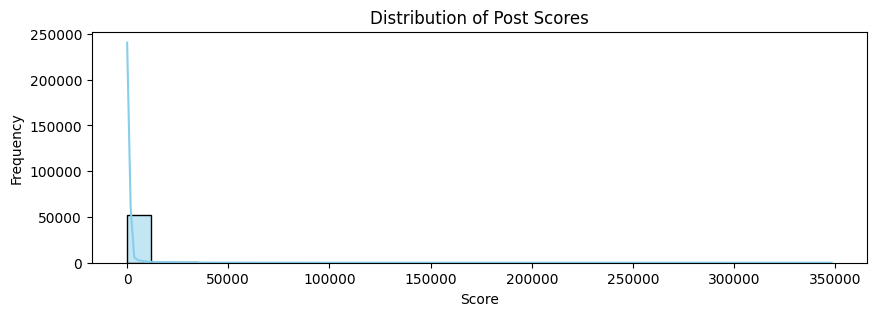

In [232]:
# Distribution plot for 'score'
plt.figure(figsize=(10, 3))
sns.histplot(df_explore['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

> We can see that lower scores are more frequent. Besides that, feature "scores" alone does not give much more information. We will try to find more insights by using the stock symbols that are more frequent in both columns, "title" and "body," and aggregating the data by date.

In [233]:
df_explore['body'] = df_explore['body'].fillna("")

### Stock Symbols

In [234]:
# Stock symbols that appear most often
stocks = ['GME', 'AMC']

# Additional variations to include
additional_variations = {'GME': ['Gamestop'], 'AMC': []}

# Columns to search for stock symbols
columns = ['title', 'body']

# Regular expressions for different variations of stock symbols
patterns = [r'\b{}\b'.format(re.escape(stock)) for stock in stocks]

# Include additional variations in the patterns
for stock, variations in additional_variations.items():
    patterns += [r'\b{}\b'.format(re.escape(variation)) for variation in variations]

# New column 'stock_symbols'
df_explore['stock_symbols'] = df_explore[columns].apply(lambda row: [stock for stock, pattern in zip(stocks, patterns) if any(re.search(pattern, cell, flags=re.I) for cell in row)], axis=1)

df_explore.head()

,title,body,score,timestamp,stock_symbols
0,"It's not about the money, it's about sending a...",,55,2021-01-28 21:37:41,[]
1,Math Professor Scott Steiner says the numbers ...,,110,2021-01-28 21:32:10,[]
2,Exit the system,The CEO of NASDAQ pushed to halt trading “to g...,0,2021-01-28 21:30:35,[GME]
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,,29,2021-01-28 21:28:57,[GME]
4,"Not to distract from GME, just thought our AMC...",,71,2021-01-28 21:26:56,"[GME, AMC]"


In [235]:
# Convert timestamp to datetime
df_explore['timestamp'] = pd.to_datetime(df_explore['timestamp'])

In [236]:
# Filter rows where GME or AMC is mentioned
gme_rows = df_explore[df_explore['stock_symbols'].apply(lambda symbols: 'GME' in symbols)]
amc_rows = df_explore[df_explore['stock_symbols'].apply(lambda symbols: 'AMC' in symbols)]

# Group by date and count the number of posts for each day
gme_counts = gme_rows.groupby(gme_rows['timestamp'].dt.date).size()
amc_counts = amc_rows.groupby(amc_rows['timestamp'].dt.date).size()

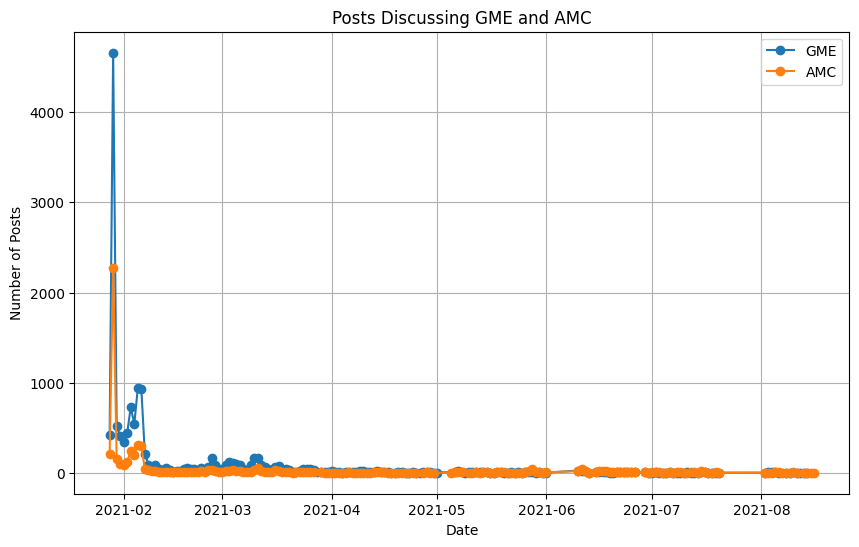

In [237]:
# Plot discussions about GME and AMC through the year
plt.figure(figsize=(10, 6))
plt.plot(gme_counts.index, gme_counts.values, label='GME', marker='o')
plt.plot(amc_counts.index, amc_counts.values, label='AMC', marker='o')

plt.title('Posts Discussing GME and AMC')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

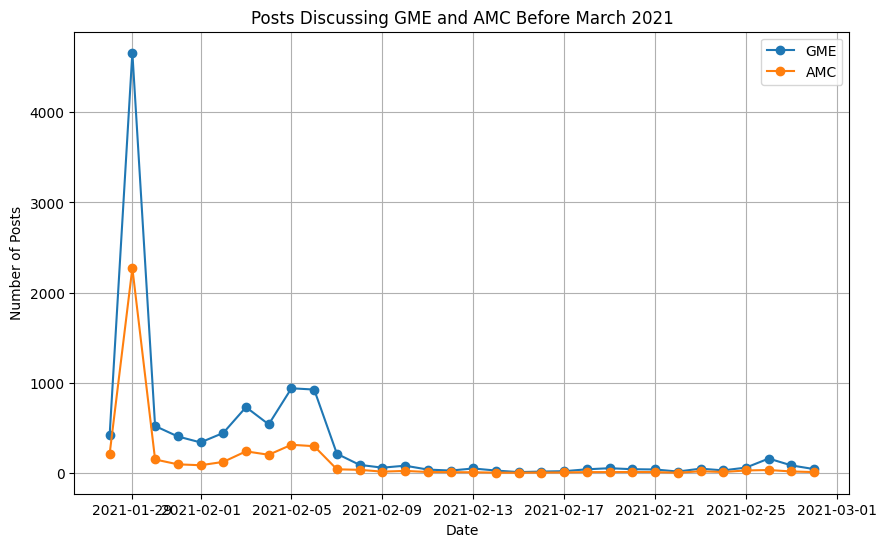

In [238]:
# Filter rows before March 2021
start_date = pd.to_datetime('2021-03-01').date()
gme_counts_before_march = gme_counts[gme_counts.index < start_date]
amc_counts_before_march = amc_counts[amc_counts.index < start_date]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(gme_counts_before_march.index, gme_counts_before_march.values, label='GME', marker='o')
plt.plot(amc_counts_before_march.index, amc_counts_before_march.values, label='AMC', marker='o')

plt.title('Posts Discussing GME and AMC Before March 2021')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

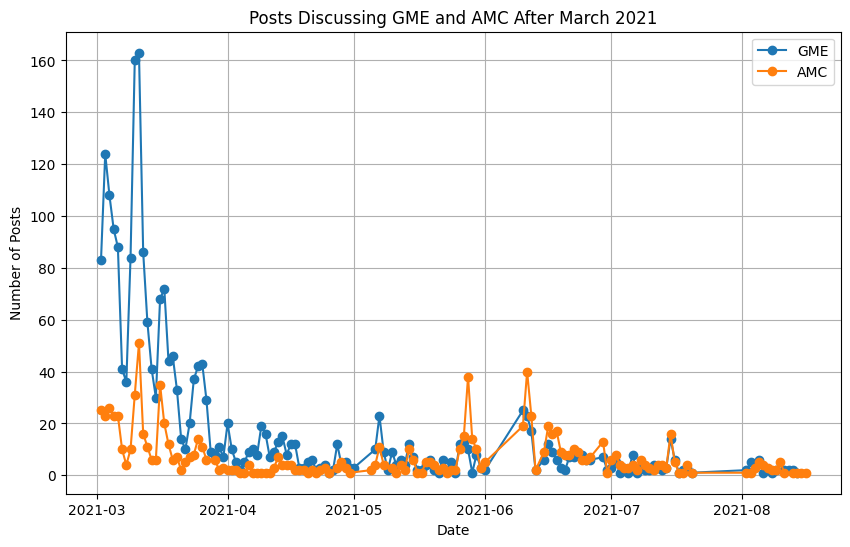

In [239]:
# Filter rows before March 2021
start_date = pd.to_datetime('2021-03-01').date()
gme_counts_after_march = gme_counts[gme_counts.index > start_date]
amc_counts_after_march = amc_counts[amc_counts.index > start_date]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(gme_counts_after_march.index, gme_counts_after_march.values, label='GME', marker='o')
plt.plot(amc_counts_after_march.index, amc_counts_after_march.values, label='AMC', marker='o')

plt.title('Posts Discussing GME and AMC After March 2021')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.show()

We can see hype around these stocks spiked in late January of 2021 with over 6000 combined posts. By April discussions had slowed to below 40 combined posts

## Sentiment Analysis

In [240]:
# Define function for text preprocessing
def preprocess_text(df):
    # Copy df
    df = df.copy()
    
    # Combine title and body text
    df['text'] = df['title'] + ' ' + df['body']
  
    # Make lowercase
    df['text'] = df['text'].str.lower()

    # Remove URLs
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))

    # Convert emojis to text
    df['text'] = df['text'].apply(lambda x: emoji.demojize(x))

    # Remove special characters
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # Remove stop words
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

    # Set 'timestamp' as the index
    df.set_index('timestamp', inplace=True)

    # Group by day and concatenate text, reset index to get back to dataframe from series (so analyze_sentiment can actually work)
    df = df.groupby(df.index.date)['text'].agg(lambda x: ' '.join(x)).reset_index()
    df.columns = ['date', 'text']
    return df

In [241]:
# Split data into GME and AMC dataframes
df_gme = df_explore[df_explore['stock_symbols'].apply(lambda x: 'GME' in x)]
df_amc = df_explore[df_explore['stock_symbols'].apply(lambda x: 'AMC' in x)]

In [242]:
# Apply preprocessing to GME and AMC dfs
df_gme = preprocess_text(df_gme)
df_amc = preprocess_text(df_amc)

In [243]:
# Define function to analyze sentiment
def analyze_sentiment(df):
    # Create a copy
    df_copy = df.copy()

    # TextBlob sentiment analysis
    df_copy['textblob_score'] = df_copy['text'].apply(lambda row: TextBlob(str(row)).sentiment.polarity)

    # VADER sentiment analysis
    sia = SentimentIntensityAnalyzer()
    df_copy['vader_score'] = df_copy['text'].apply(lambda row: sia.polarity_scores(str(row))['compound'])

    # Set date as index
    df_copy.set_index('date', inplace=True)

    return df_copy

In [244]:
# Analyze sentiment
df_gme = analyze_sentiment(df_gme)
df_amc = analyze_sentiment(df_amc)

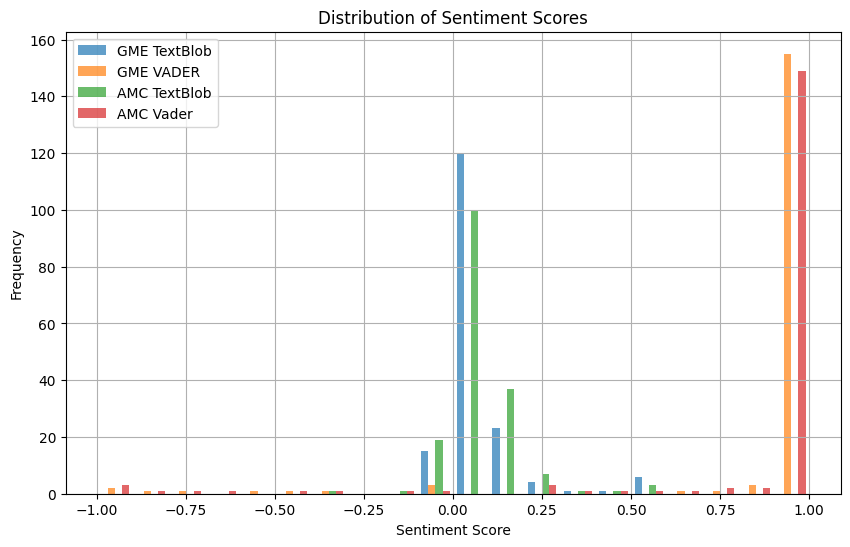

In [245]:
# Plot distribution of scores
plt.figure(figsize=(10, 6))
plt.hist([df_gme['textblob_score'], df_gme['vader_score'], df_amc['textblob_score'], df_amc['vader_score']], bins=20, label=['GME TextBlob', 'GME VADER','AMC TextBlob', 'AMC Vader'], alpha=0.7)

plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

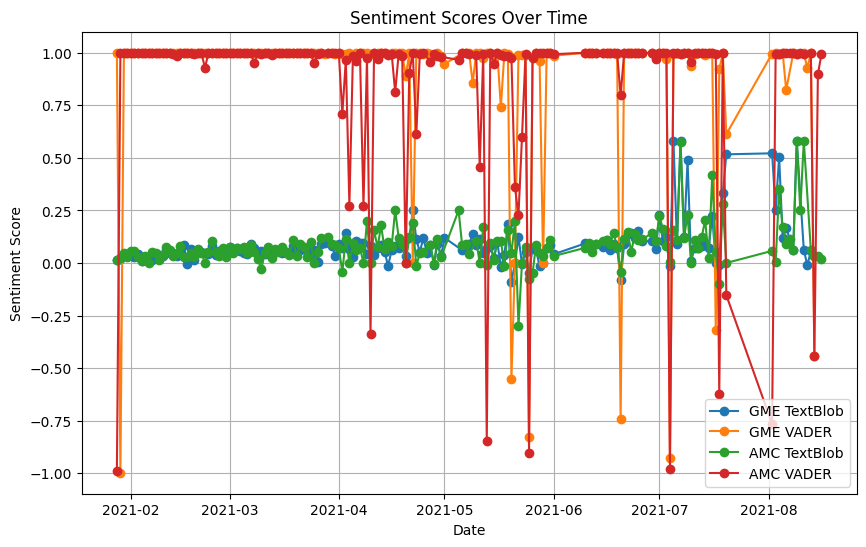

In [246]:
# Plot score changes over the year
plt.figure(figsize=(10, 6))
plt.plot(df_gme.index, df_gme['textblob_score'], label='GME TextBlob', marker='o')
plt.plot(df_gme.index, df_gme['vader_score'], label='GME VADER', marker='o')
plt.plot(df_amc.index, df_amc['textblob_score'], label='AMC TextBlob', marker='o')
plt.plot(df_amc.index, df_amc['vader_score'], label='AMC VADER', marker='o')

plt.title('Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

VADER tends to score with much more variability than TextBlob, with most days having maximum positive sentiment. Aside from an intial negative day, VADER does not classify any days as negative until April. TextBlob began the mostly neutral but by July classifies much more positively. 

In [247]:
# Define a function to label sentiment as positive, neutral, or negative
def label_sentiment(df):
    df=df.copy()
    # Set threshold values
    # Textblob has a lower threshold as its values were more sensitive
    # Threshold values were completely subjectively chosen
    textblob_threshold = 0.05
    vader_threshold = 0.1

    # Use pd.cut to add scores into bins based on threshold values above. 
    df['textblob_label'] = pd.cut(df['textblob_score'], bins=[float('-inf'), -textblob_threshold, textblob_threshold, float('inf')],
                                labels=['negative', 'neutral', 'positive'])
    
    df['vader_label'] = pd.cut(df['vader_score'], bins=[float('-inf'), -vader_threshold, vader_threshold, float('inf')],
                                labels=['negative', 'neutral', 'positive'])
    return df
    

In [248]:
# Label sentiments
df_gme = label_sentiment(df_gme)
df_amc = label_sentiment(df_amc)

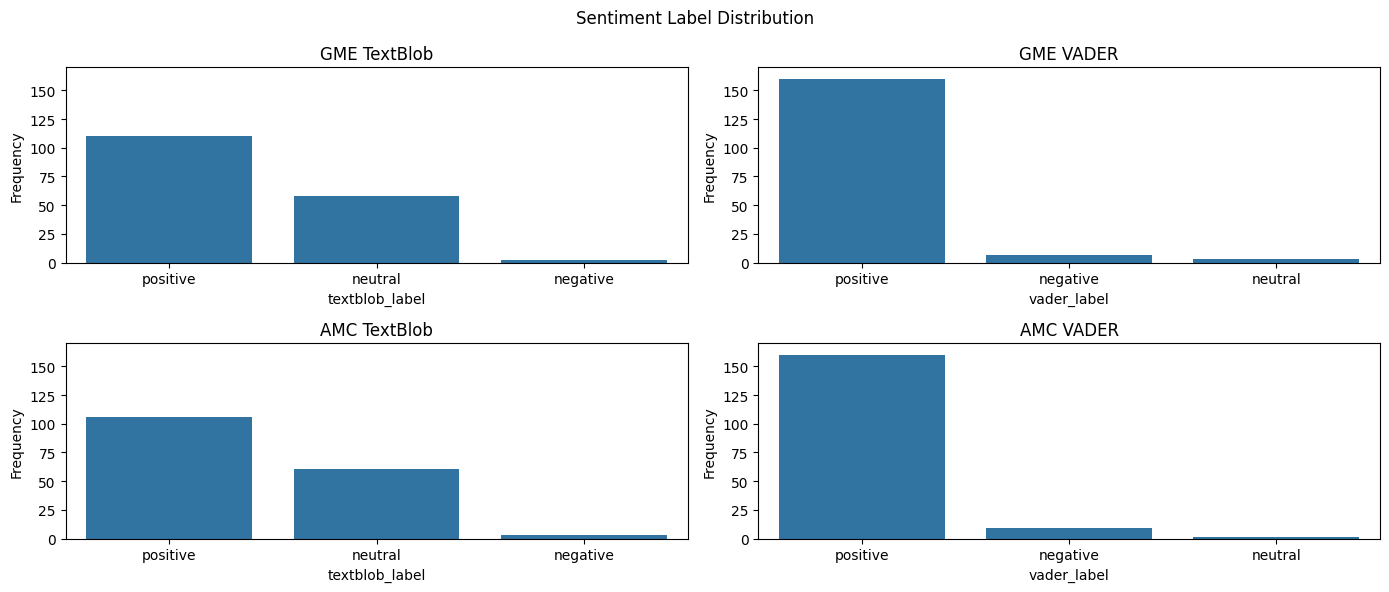

In [249]:
# Count plots for sentiment labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))

# GME TextBlob Distribution Plot
sns.countplot(data=df_gme, x='textblob_label', order=df_gme['textblob_label'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title('GME TextBlob')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_ylim(0, 170)  # Set y-axis limits

# GME VADER Distribution Plot
sns.countplot(data=df_gme, x='vader_label', order=df_gme['vader_label'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title('GME VADER')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_ylim(0, 170)

# AMC TextBlob Distribution Plot
sns.countplot(data=df_amc, x='textblob_label', order=df_amc['textblob_label'].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title('AMC TextBlob')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_ylim(0, 170)

# AMC VADER Distribution Plot
sns.countplot(data=df_amc, x='vader_label', order=df_amc['vader_label'].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title('AMC VADER')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_ylim(0, 170)

plt.suptitle('Sentiment Label Distribution')
plt.tight_layout()
plt.show()

We can see the community is generally speaking much more positively about both GME and AMC than negatively. TextBlob is classifying more of the discussion as neutral instead of positive than VADER.

## YFinance

In [250]:
# Get stock prices
amc_data = yf.download('AMC', start='2021-01-28', end='2021-08-14')
gme_data = yf.download('GME', start='2021-01-28', end='2021-08-14')
# Choose columns
amc_data = amc_data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
gme_data = gme_data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


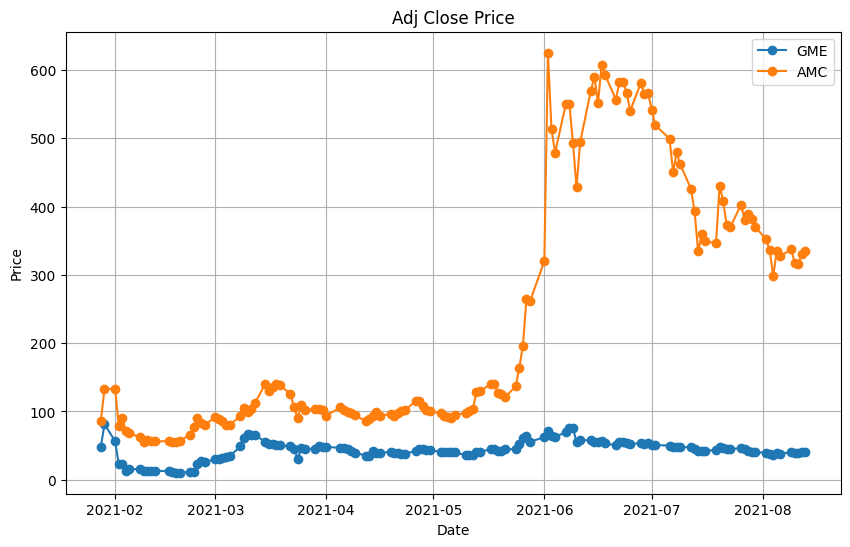

In [251]:
# Plot Adj Close 
plt.figure(figsize=(10, 6))
plt.plot(gme_data.index, gme_data['Adj Close'], label='GME', marker='o')
plt.plot(amc_data.index, amc_data['Adj Close'], label='AMC', marker='o')

plt.title('Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

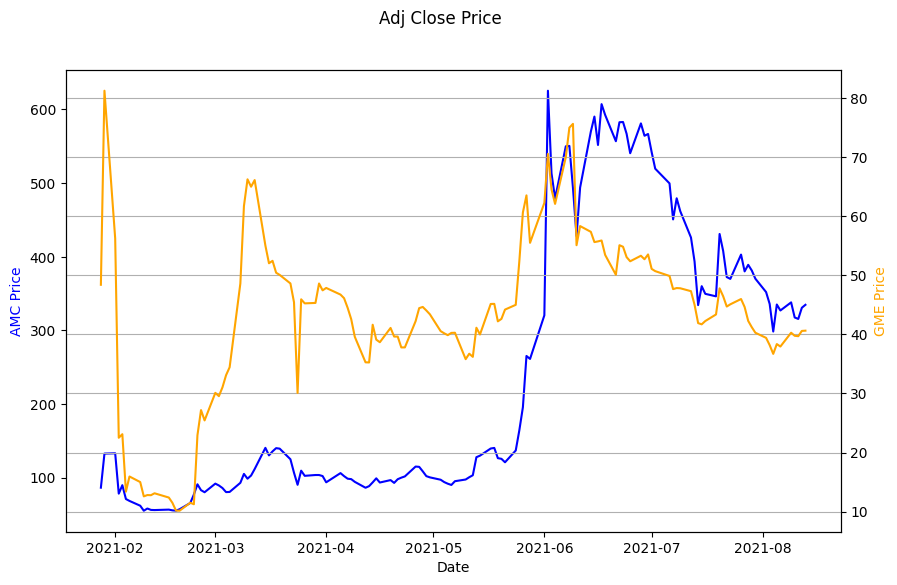

In [252]:
# Plot Adj Close
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot AMC
ax1.plot(amc_data.index, amc_data['Adj Close'], color='blue')
ax1.set_ylabel('AMC Price', color='blue')
ax1.set_xlabel('Date')

# Create a right y-axis for GME
ax2 = ax1.twinx()
ax2.plot(gme_data.index, gme_data['Adj Close'], color='orange')
ax2.set_ylabel('GME Price', color='orange')


plt.suptitle('Adj Close Price')
plt.grid(True)
plt.show()

GME see relatively higher spikes than AMC until June at whcih point AMC sees a massive climb in price to similarly high relative price levels. They both fall after that peak. 

In [253]:
# Calculate the difference between the open of one day and the close of the previous day using shift
amc_data['Open_Close_Difference'] = amc_data['Open'] - amc_data['Adj Close'].shift(1)
gme_data['Open_Close_Difference'] = gme_data['Open'] - gme_data['Adj Close'].shift(1)
# Add a 'Change' column to show an increase or decrease in price
amc_data['Change'] = pd.cut(amc_data['Open_Close_Difference'], bins=[float('-inf'), 0, float('inf')], labels=['Decreased', 'Increased'])
gme_data['Change'] = pd.cut(gme_data['Open_Close_Difference'], bins=[float('-inf'), 0, float('inf')], labels=['Decreased', 'Increased'])

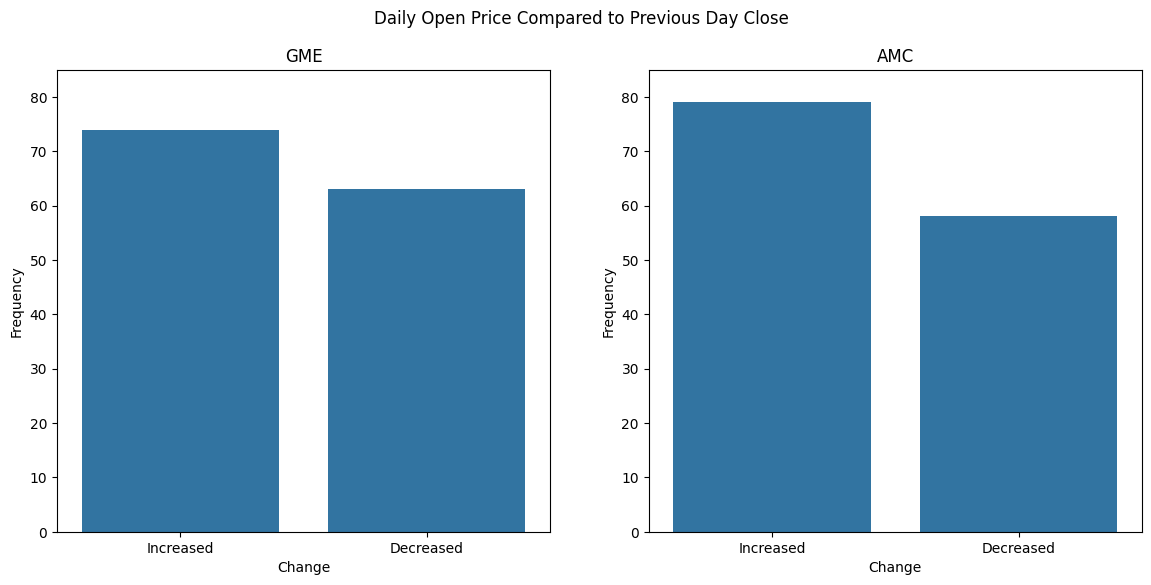

In [254]:
# Count plots for change
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# GME change distribution
sns.countplot(data=gme_data, x='Change', order=gme_data['Change'].value_counts().index, ax=axes[0])
axes[0].set_title('GME')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0, 85)  #Set y-axis limits

# AMC Change Distribution
sns.countplot(data=amc_data, x='Change', order=amc_data['Change'].value_counts().index, ax=axes[1])
axes[1].set_title('AMC')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0, 85)

plt.suptitle('Daily Open Price Compared to Previous Day Close')
plt.show()

## Evaluation

In [255]:
# Merge with yfinance and sentiment dataframes
merged_gme = pd.merge(df_gme, gme_data, left_index=True, right_index=True, how='left')
merged_amc = pd.merge(df_amc, amc_data, left_index=True, right_index=True, how='left')

In [256]:
# Check for days textblob is correct when the sentiment is positive and the next day's change is an increase or the sentiment is negative and the next day's change is a decrease
merged_amc['textblob_correct'] = ((merged_amc['textblob_label'] == 'positive') & (merged_amc['Change'].shift(-1) == 'Increased')) | ((merged_amc['textblob_label'] == 'negative') & (merged_amc['Change'].shift(-1) == 'Decreased'))
amc_textblob_correct = (merged_amc['textblob_correct'].sum()/merged_amc['textblob_correct'].count())*100
print(f'AMC TextBlob is {amc_textblob_correct:.2f} % correct')
# Create the 'vader_correct' column
merged_amc['vader_correct'] = ((merged_amc['vader_label'] == 'positive') & (merged_amc['Change'].shift(-1) == 'Increased')) | ((merged_amc['vader_label'] == 'negative') & (merged_amc['Change'].shift(-1) == 'Decreased'))
amc_vader_correct = (merged_amc['vader_correct'].sum()/merged_amc['vader_correct'].count())*100
print(f'AMC VADER is {amc_vader_correct:.2f} % correct')

# Repeat for GME
merged_gme['textblob_correct'] = ((merged_gme['textblob_label'] == 'positive') & (merged_gme['Change'].shift(-1) == 'Increased')) | ((merged_gme['textblob_label'] == 'negative') & (merged_gme['Change'].shift(-1) == 'Decreased'))
gme_textblob_correct = (merged_gme['textblob_correct'].sum()/merged_gme['textblob_correct'].count())*100
print(f'GME TextBlob is {gme_textblob_correct:.2f} % correct')
merged_gme['vader_correct'] = ((merged_gme['vader_label'] == 'positive') & (merged_gme['Change'].shift(-1) == 'Increased')) | ((merged_gme['vader_label'] == 'negative') & (merged_gme['Change'].shift(-1) == 'Decreased'))
gme_vader_correct = (merged_gme['vader_correct'].sum()/merged_gme['vader_correct'].count())*100
print(f'GME VADER is {gme_vader_correct:.2f} % correct')


AMC TextBlob is 25.88 % correct
AMC VADER is 40.00 % correct
GME TextBlob is 26.47 % correct
GME VADER is 35.29 % correct


VADER sees higher accuracy than TextBlob in both AMC and GME. Both are below 50% accuracy

Ultimately the exercise fails to reach conclusive results and sentiment analysis of this community fails to provide any actionable insights into predicting the movement of the stocks discussed online. 

This is probably due to some level of bias; those most likely to post in communities discussing get rich quick stocks are likely to be those most positive and excited about the stocks. This is why the sentiment was overwhelming positive despite only have slightly more positive than negative days.